# Z-Order Notebook

This notebook performs the following operations:

- Create Delta Lake tables
- Generate data and insert it into the table
- Apply Z-Order optimization
- Display table properties
- Run queries
- Display query execution time

In [6]:
spark.stop()

In [1]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("ZOrder") \
    .master("spark://192.168.0.144:7077") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://192.168.0.144:9083") \
    .config("spark.hadoop.javax.jdo.option.ConnectionURL", "jdbc:mysql://192.168.0.144:3306/metastore_db") \
    .config("spark.hadoop.javax.jdo.option.ConnectionDriverName", "com.mysql.cj.jdbc.Driver") \
    .config("spark.hadoop.javax.jdo.option.ConnectionUserName", "lh") \
    .config("spark.hadoop.javax.jdo.option.ConnectionPassword", os.getenv('MYSQL', 'Default_Value')) \
    .config("spark.jars", "/usr/local/spark/jars/delta-storage-3.2.0.jar,/usr/local/spark/jars/delta-spark_2.12-3.2.0.jar")    \
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.HDFSLogStore") \
    .config("spark.executor.memory", "9g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "19g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.0.144:9000") \
    .config("spark.databricks.delta.clusteredTable.enableClusteringTablePreview", "true") \
    .config("spark.sql.debug.maxToStringFields", "1000") \
    .enableHiveSupport() \
    .getOrCreate()

24/08/08 06:46:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
print("Databases:")
spark.sql("SHOW DATABASES").show()
spark.sql("USE zorder")
print("Tables in 'zorder' database:")
spark.sql("SHOW TABLES").show(truncate=False)

Databases:
+----------------+
|       namespace|
+----------------+
|      compaction|
|         default|
|liquidclustering|
|       partition|
|    pyspark_test|
|        raw_data|
|      scala_test|
|          zorder|
+----------------+

Tables in 'zorder' database:
+---------+------------------------------+-----------+
|namespace|tableName                     |isTemporary|
+---------+------------------------------+-----------+
|zorder   |campaign_dim                  |false      |
|zorder   |customer_dim                  |false      |
|zorder   |department_dim                |false      |
|zorder   |location_dim                  |false      |
|zorder   |product_dim                   |false      |
|zorder   |pyspark_test_2                |false      |
|zorder   |pyspark_test_4                |false      |
|zorder   |pyspark_test_8                |false      |
|zorder   |zorder_eventid_actorid_table_2|false      |
|zorder   |zorder_eventid_actorid_table_4|false      |
|zorder   |zorde

In [2]:
db='zorder'
delta_db_path = 'hdfs://192.168.0.144:9000/datalake/zorder'

In [26]:
#spark.sql(f"drop DATABASE {db} CASCADE")
#spark.sql(f"CREATE DATABASE {db} LOCATION '{delta_db_path}'")
spark.sql(f"use database zorder")

DataFrame[]

In [7]:
import subprocess
import matplotlib.pyplot as plt
import random
from pyspark.sql.functions import lit, rand, expr, year, month, dayofmonth, concat, lpad, element_at, array
from pyspark.sql.types import StringType, StructType, StructField, DateType, TimestampType, DoubleType, LongType, IntegerType
from pyspark.sql import SparkSession
from datetime import datetime, timedelta
import itertools
import random
from pyspark.sql.functions import lit, rand, udf, col, expr, year, month, dayofmonth, concat, lpad
from pyspark.sql.types import StringType


# Parameters
num_pairs = 3  # Number of table pairs to create
max_rows = 8  # Maximum number of rows for the largest table 8000000000

row_counts = [max_rows // (2 ** i) for i in range(num_pairs)]


"""
Create and initialize a specified number of partitioned and non-partitioned Delta Lake tables.
Each pair of tables (partitioned and non-partitioned) is dropped if it exists and then recreated 
with the specified schema.
"""
for i in range(num_pairs):
    zorder_table_name = f"zorder_eventid_actorid_table_{row_counts[i]}"
    zorder_table_name_sd = f"zorder_eventid_table_{row_counts[i]}"
    
    spark.sql(f"DROP TABLE IF EXISTS {zorder_table_name}")
    spark.sql(f"DROP TABLE IF EXISTS {zorder_table_name_sd}")
    
    spark.sql(f"""
    CREATE TABLE {zorder_table_name} (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)

    spark.sql(f"""
    CREATE TABLE {zorder_table_name_sd} (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta;
    """)





24/07/29 20:36:27 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_eventid_actorid_table_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 20:36:27 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/07/29 20:36:30 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_eventid_table_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 20:36:31 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`zorder`.`zorder_eventid_actorid_table_4` into Hive metastore in Spark SQL specific format, which is NOT compat

In [11]:
from delta.tables import DeltaTable

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_2",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_4",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    table_name = path.split("/")[-1]
    print(f"Optimizing table: {table_name}")
    %time delta_table_obj.optimize().executeZOrderBy("event_id", "actor_id")


table_paths = [
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_2",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_4",
    "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_8"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    table_name = path.split("/")[-1]
    print(f"Optimizing table: {table_name}")
    %time delta_table_obj.optimize().executeZOrderBy("event_id")

Optimizing table: zorder_eventid_actorid_table_2


CPU times: user 1.3 s, sys: 2.06 s, total: 3.36 s
Wall time: 51min 9s
Optimizing table: zorder_eventid_actorid_table_4


CPU times: user 2.84 s, sys: 3.9 s, total: 6.74 s
Wall time: 1h 52min 8s
Optimizing table: zorder_eventid_actorid_table_8


CPU times: user 6.01 s, sys: 8.46 s, total: 14.5 s
Wall time: 3h 57min 26s
Optimizing table: zorder_eventid_table_2


CPU times: user 1.16 s, sys: 1.74 s, total: 2.9 s
Wall time: 46min 4s
Optimizing table: zorder_eventid_table_4


CPU times: user 2.66 s, sys: 3.28 s, total: 5.94 s
Wall time: 1h 46min 18s
Optimizing table: zorder_eventid_table_8


CPU times: user 5.98 s, sys: 7.22 s, total: 13.2 s
Wall time: 4h 1min 54s


In [42]:
spark.sql("""
show tables
""").show(truncate = False)


+---------+--------------------------------+-----------+
|namespace|tableName                       |isTemporary|
+---------+--------------------------------+-----------+
|zorder   |nozorder_eventid_actorid_table_2|false      |
|zorder   |nozorder_eventid_actorid_table_4|false      |
|zorder   |nozorder_eventid_actorid_table_8|false      |
|zorder   |zorder_eventid_actorid_table_2  |false      |
|zorder   |zorder_eventid_actorid_table_4  |false      |
|zorder   |zorder_eventid_actorid_table_8  |false      |
|zorder   |zorder_eventid_table_2          |false      |
|zorder   |zorder_eventid_table_4          |false      |
|zorder   |zorder_eventid_table_8          |false      |
+---------+--------------------------------+-----------+



In [13]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


tables = [
    "zorder_eventid_table_2",
    "zorder_eventid_table_4",
    "zorder_eventid_table_8",
    "zorder_eventid_actorid_table_2",
    "zorder_eventid_actorid_table_4",
    "zorder_eventid_actorid_table_8"
]


num_executions = 5

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"""
        SELECT
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country,
            SUM({table}.value) AS total_value,
            COUNT({table}.event_id) AS event_count
        FROM
            {table}
        JOIN
            product_dim ON {table}.product_id = product_dim.product_id
        JOIN
            location_dim ON {table}.location_id = location_dim.location_id
        WHERE
            {table}.event_id BETWEEN 459999 AND 999999  
            AND {table}.actor_id IN (5001, 5002, 5003)  
        GROUP BY
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country
        ORDER BY
            total_value DESC;"""
        
        try:
            execution_time = measure_execution_time(query)
            print(f"{table}: {execution_time} seconds")
            execution_times[table].append(execution_time)
        except Exception as e:
            print(f"Error for table {table}: {e}")

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])
print(df)

plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546517|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393488|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA| 16259.04758088331|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725005|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983137|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552864|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536648|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546511|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393488|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983136|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609756|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333416|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA| 16205.66811772501|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952987|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536643|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546508|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333425|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552864|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952987|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536646|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 16325.64538454651|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983136|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609763|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333418|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155287|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725005|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952985|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804069|      65019|
|   Product F|Philadelphia|   PA|    USA| 32505.90435761468|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205585|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678734|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561026|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691844|      64856|
|   Product J|    San Jose|   CA|    USA| 32261.38152139002|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656354|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212643|      64419|
|   Product I|      Dallas|   TX|    USA| 32112.47699721469|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 32562.84644804068|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614676|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205583|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678723|      64775|
|   Product C|     Chicago|   IL|    USA| 32414.75773356101|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691833|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390027|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656358|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212636|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214686|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|32562.846448040687|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614676|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055833|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678734|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561026|      64872|
|   Product H|   San Diego|   CA|    USA| 32358.99064869183|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521389998|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656354|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212643|      64419|
|   Product I|      Dallas|   TX|    USA| 32112.47699721469|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|32562.846448040687|      65019|
|   Product F|Philadelphia|   PA|    USA|32505.904357614687|      64727|
|   Product D|     Houston|   TX|    USA|32455.605562055825|      64944|
|   Product B| Los Angeles|   CA|    USA|32439.405046678745|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561022|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691837|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390016|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656354|      64622|
|   Product E|     Phoenix|   AZ|    USA| 32179.81861421264|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214704|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|  32562.8464480407|      65019|
|   Product F|Philadelphia|   PA|    USA|  32505.9043576147|      64727|
|   Product D|     Houston|   TX|    USA| 32455.60556205583|      64944|
|   Product B| Los Angeles|   CA|    USA| 32439.40504667874|      64775|
|   Product C|     Chicago|   IL|    USA|32414.757733561037|      64872|
|   Product H|   San Diego|   CA|    USA|32358.990648691815|      64856|
|   Product J|    San Jose|   CA|    USA|32261.381521390012|      64522|
|   Product G| San Antonio|   TX|    USA|32260.084995656358|      64622|
|   Product E|     Phoenix|   AZ|    USA|32179.818614212643|      64419|
|   Product I|      Dallas|   TX|    USA|32112.476997214686|      64561|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA|65068.694503717285|     129858|
|   Product H|   San Diego|   CA|    USA|65025.955152427305|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117504|     129584|
|   Product D|     Houston|   TX|    USA|  64751.8960702792|     129594|
|   Product C|     Chicago|   IL|    USA|  64710.9935498963|     129489|
|   Product F|Philadelphia|   PA|    USA|64700.051403774785|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941272|     129185|
|   Product J|    San Jose|   CA|    USA|64539.430692354275|     129137|
|   Product A|    New York|   NY|    USA| 64461.43829623051|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083323|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA|65068.694503717306|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242732|     129806|
|   Product I|      Dallas|   TX|    USA| 64772.63872117505|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027923|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989627|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377483|     129374|
|   Product B| Los Angeles|   CA|    USA|64590.336909412705|     129185|
|   Product J|    San Jose|   CA|    USA|64539.430692354355|     129137|
|   Product A|    New York|   NY|    USA|64461.438296230524|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083322|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371725|     129858|
|   Product H|   San Diego|   CA|    USA|65025.955152427305|     129806|
|   Product I|      Dallas|   TX|    USA|64772.638721175026|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027924|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989627|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377476|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941274|     129185|
|   Product J|    San Jose|   CA|    USA|64539.430692354385|     129137|
|   Product A|    New York|   NY|    USA|64461.438296230466|     129076|
|   Product G| San Antonio|   TX|    USA|64429.902800833246|     129012|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product E|     Phoenix|   AZ|    USA| 65068.69450371721|     129858|
|   Product H|   San Diego|   CA|    USA| 65025.95515242729|     129806|
|   Product I|      Dallas|   TX|    USA|64772.638721175084|     129584|
|   Product D|     Houston|   TX|    USA| 64751.89607027922|     129594|
|   Product C|     Chicago|   IL|    USA| 64710.99354989629|     129489|
|   Product F|Philadelphia|   PA|    USA| 64700.05140377481|     129374|
|   Product B| Los Angeles|   CA|    USA| 64590.33690941275|     129185|
|   Product J|    San Jose|   CA|    USA|64539.430692354385|     129137|
|   Product A|    New York|   NY|    USA|64461.438296230444|     129076|
|   Product G| San Antonio|   TX|    USA| 64429.90280083319|     129012|
+------------+------------+-----+-------+----------

ERROR:root:KeyboardInterrupt while sending command.            (323 + 15) / 719]
Traceback (most recent call last):
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/lh/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [5]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


tables = [
    "zorder_eventid_table_2"
]


num_executions = 10

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"""
        SELECT
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country,
            SUM({table}.value) AS total_value,
            COUNT({table}.event_id) AS event_count
        FROM
            {table}
        JOIN
            product_dim ON {table}.product_id = product_dim.product_id
        JOIN
            location_dim ON {table}.location_id = location_dim.location_id
        WHERE
            {table}.event_id BETWEEN 459999 AND 999999  
            AND {table}.actor_id IN (5001, 5002, 5003)  
        GROUP BY
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country
        ORDER BY
            total_value DESC;"""
        
        try:
            execution_time = measure_execution_time(query)
            print(f"{table}: {execution_time} seconds")
            execution_times[table].append(execution_time)
        except Exception as e:
            print(f"Error for table {table}: {e}")

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}
print(average_times)


+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393486|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983134|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883309|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609752|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333423|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA| 16205.66811772501|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536641|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393494|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983134|      32449|
|   Product F|Philadelphia|   PA|    USA|  16259.0475808833|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609763|      32430|
|   Product I|      Dallas|   TX|    USA| 16214.70081633342|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155287|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725018|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952994|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536641|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 16325.64538454652|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983126|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883305|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609754|      32430|
|   Product I|      Dallas|   TX|    USA| 16214.70081633342|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552864|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952987|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA| 16293.04177339349|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983137|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883298|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609754|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333423|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552871|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725003|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952992|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 16325.64538454652|      32631|
|   Product A|    New York|   NY|    USA| 16293.04177339349|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983125|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552871|      32367|
|   Product J|    San Jose|   CA|    USA|   16205.668117725|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883309|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA| 16205.66811772501|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952998|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393488|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883303|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333414|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552862|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536635|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546508|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883313|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609762|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333414|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536648|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA| 16293.04177339348|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|  16259.0475808833|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609756|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333416|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536641|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 16325.64538454651|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393488|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983126|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333414|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552871|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952994|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536637|      31985|
+------------+------------+-----+-------+----------

In [4]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as spark_sum, count
from pyspark.sql.types import StructType, StructField, StringType


tables = [
    "zorder_eventid_table_2"
]

num_executions = 10

def measure_execution_time(df):
    spark.catalog.clearCache()
    start_time = time.time()
    df.show() 
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:

    main_df = spark.table(table)
    product_dim_df = spark.table("product_dim")
    location_dim_df = spark.table("location_dim")
    
    for _ in range(num_executions):
        try:
            result_df = (
                main_df
                .join(product_dim_df, col(f"{table}.product_id") == col("product_dim.product_id"))
                .join(location_dim_df, col(f"{table}.location_id") == col("location_dim.location_id"))
                .filter((col(f"{table}.event_id").between(459999, 999999)) & (col(f"{table}.actor_id").isin(5001, 5002, 5003)))
                .groupBy("product_dim.product_name", "location_dim.city", "location_dim.state", "location_dim.country")
                .agg(
                    spark_sum(col(f"{table}.value")).alias("total_value"),
                    count(col(f"{table}.event_id")).alias("event_count")
                )
                .orderBy(col("total_value").desc())
            )
            
            execution_time = measure_execution_time(result_df)
            print(f"{table}: {execution_time} seconds")
            execution_times[table].append(execution_time)
        except Exception as e:
            print(f"Error for table {table}: {e}")

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

print(average_times)


+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546522|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393494|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983132|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883305|      32521|
|   Product H|   San Diego|   CA|    USA| 16238.37785360976|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333425|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552875|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA| 16293.04177339348|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883305|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609763|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333427|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552868|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952992|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546518|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333418|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552875|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536643|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546517|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393486|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983134|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883307|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333418|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552862|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952989|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393492|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983125|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883302|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609747|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333423|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155286|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952992|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546511|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393486|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883298|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609762|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155287|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725012|      32434|
|   Product D|     Houston|   TX|    USA| 16115.73627295299|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536637|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983136|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883294|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609754|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333425|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552866|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725008|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952992|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536645|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546513|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393483|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983128|      32449|
|   Product F|Philadelphia|   PA|    USA| 16259.04758088331|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609763|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333425|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552875|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952996|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536634|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA| 16260.50695098313|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883309|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333416|      32415|
|   Product C|     Chicago|   IL|    USA| 16212.33496155286|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725007|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952978|      32344|
|   Product E|     Phoenix|   AZ|    USA|15993.698453536648|      31985|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|16325.645384546515|      32631|
|   Product A|    New York|   NY|    USA|16293.041773393485|      32485|
|   Product B| Los Angeles|   CA|    USA|16260.506950983132|      32449|
|   Product F|Philadelphia|   PA|    USA|16259.047580883303|      32521|
|   Product H|   San Diego|   CA|    USA|16238.377853609758|      32430|
|   Product I|      Dallas|   TX|    USA|16214.700816333421|      32415|
|   Product C|     Chicago|   IL|    USA|16212.334961552866|      32367|
|   Product J|    San Jose|   CA|    USA|16205.668117725016|      32434|
|   Product D|     Houston|   TX|    USA|16115.736272952987|      32344|
|   Product E|     Phoenix|   AZ|    USA| 15993.69845353664|      31985|
+------------+------------+-----+-------+----------

In [ ]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


tables = [
    "zorder_eventid_table_2",
    "zorder_eventid_table_4",
    "zorder_eventid_table_8",
    "zorder_eventid_actorid_table_2",
    "zorder_eventid_actorid_table_4",
    "zorder_eventid_actorid_table_8"
]


num_executions = 5

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"""
        SELECT
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country,
            SUM({table}.value) AS total_value,
            COUNT({table}.event_id) AS event_count
        FROM
            {table}
        JOIN
            product_dim ON {table}.product_id = product_dim.product_id
        JOIN
            location_dim ON {table}.location_id = location_dim.location_id
        WHERE
            {table}.event_id BETWEEN 459999 AND 999999  
            AND {table}.actor_id IN (5001, 5002, 5003)  
        GROUP BY
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country
        ORDER BY
            total_value DESC;"""
        
        try:
            execution_time = measure_execution_time(query)
            print(f"{table}: {execution_time} seconds")
            execution_times[table].append(execution_time)
        except Exception as e:
            print(f"Error for table {table}: {e}")

# Calculate average execution time
average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

# Create DataFrame for plotting
df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])
print(df)

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [10]:
table_pairs = [
    ('zorder.zorder_eventid_actorid_table_8', 'raw_data.raw_data_8'),
    ('zorder.zorder_eventid_table_8', 'raw_data.raw_data_8'),
    ('zorder.zorder_eventid_actorid_table_4', 'raw_data.raw_data_4'),
    ('zorder.zorder_eventid_table_4', 'raw_data.raw_data_4'),
    ('zorder.zorder_eventid_actorid_table_2', 'raw_data.raw_data_2'),
    ('zorder.zorder_eventid_table_2', 'raw_data.raw_data_2'),
]

for target_table, source_table in table_pairs:
    insert_sql = f"""
    INSERT INTO {target_table}
    SELECT * FROM {source_table}
    """
    print(f"Inserting data for table {target_table}")
    %time spark.sql(insert_sql)


Inserting data for table zorder.zorder_eventid_actorid_table_8


CPU times: user 2.22 s, sys: 2.07 s, total: 4.29 s
Wall time: 1h 47min 29s
Inserting data for table zorder.zorder_eventid_table_8


CPU times: user 2.21 s, sys: 1.62 s, total: 3.83 s
Wall time: 1h 44min 42s
Inserting data for table zorder.zorder_eventid_actorid_table_4


CPU times: user 1.12 s, sys: 753 ms, total: 1.87 s
Wall time: 54min 13s
Inserting data for table zorder.zorder_eventid_table_4


CPU times: user 1.09 s, sys: 906 ms, total: 2 s
Wall time: 49min 49s
Inserting data for table zorder.zorder_eventid_actorid_table_2


CPU times: user 475 ms, sys: 518 ms, total: 993 ms
Wall time: 25min 41s
Inserting data for table zorder.zorder_eventid_table_2


CPU times: user 640 ms, sys: 307 ms, total: 947 ms
Wall time: 28min 50s


In [12]:
from delta.tables import DeltaTable

spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")

table_paths = [
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_2',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_4',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_8',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_2',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_4',
    'hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8'
]

for path in table_paths:
    print(f"Deleting unused files for table {path}")
    delta_table_obj = DeltaTable.forPath(spark, path)
    %time delta_table_obj.vacuum(0)



Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_2


Deleted 330 files and directories in a total of 1 directories.
CPU times: user 77.8 ms, sys: 66.4 ms, total: 144 ms
Wall time: 38.1 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_4


Deleted 647 files and directories in a total of 1 directories.
CPU times: user 44.4 ms, sys: 100 ms, total: 145 ms
Wall time: 21.1 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_table_8


Deleted 1293 files and directories in a total of 1 directories.
CPU times: user 48.9 ms, sys: 84.8 ms, total: 134 ms
Wall time: 20.9 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_2


Deleted 330 files and directories in a total of 1 directories.
CPU times: user 67.8 ms, sys: 78.6 ms, total: 146 ms
Wall time: 18.8 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_4


Deleted 647 files and directories in a total of 1 directories.
CPU times: user 18.6 ms, sys: 152 ms, total: 171 ms
Wall time: 18.7 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8


Deleted 1293 files and directories in a total of 1 directories.
CPU times: user 42.4 ms, sys: 93.7 ms, total: 136 ms
Wall time: 19.6 s


In [ ]:
                              Table  Average Execution Time
0  nozorder_eventid_actorid_table_2              233.319613
1  nozorder_eventid_actorid_table_4              461.165444
2  nozorder_eventid_actorid_table_8              989.810002
3            zorder_eventid_table_2               66.869337
4            zorder_eventid_table_4              237.478777
5            zorder_eventid_table_8              443.057015
6    zorder_eventid_actorid_table_2               14.115593
7    zorder_eventid_actorid_table_4               35.281418
8    zorder_eventid_actorid_table_8               45.288971

In [29]:
average_times_part1_before = {
    'small_table\n($2\\times10^9$ rows)': 233.319613,
    'medium_table\n($4\\times10^9$ rows)': 461.165444,
    'big_table\n($8\\times10^9$ rows)': 989.810002
}
average_times_part2_before = {
    'small_table\n($2\\times10^9$ rows)': 233.319613,
    'medium_table\n($4\\times10^9$ rows)': 461.165444,
    'big_table\n($8\\times10^9$ rows)': 989.810002
}


average_times_part1_after = {
    'small_table\n($2\\times10^9$ rows)': 66.869337,
    'medium_table\n($4\\times10^9$ rows)': 237.478777,
    'big_table\n($8\\times10^9$ rows)': 443.057015
}

average_times_part2_after = {
    'small_table\n($2\\times10^9$ rows)': 14.115593,
    'medium_table\n($4\\times10^9$ rows)': 35.281418,
    'big_table\n($8\\times10^9$ rows)': 45.288971
}

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_comparison(before_times, after_times, query_num):

    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  

    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})


    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Z-Order"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Z-Order"])
    df = df_before.merge(df_after, on="Table")

    df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Query 1, Z-Order column {query_num})')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'zorder_table_performance_{query_num}.png', dpi=500)
    plt.show()

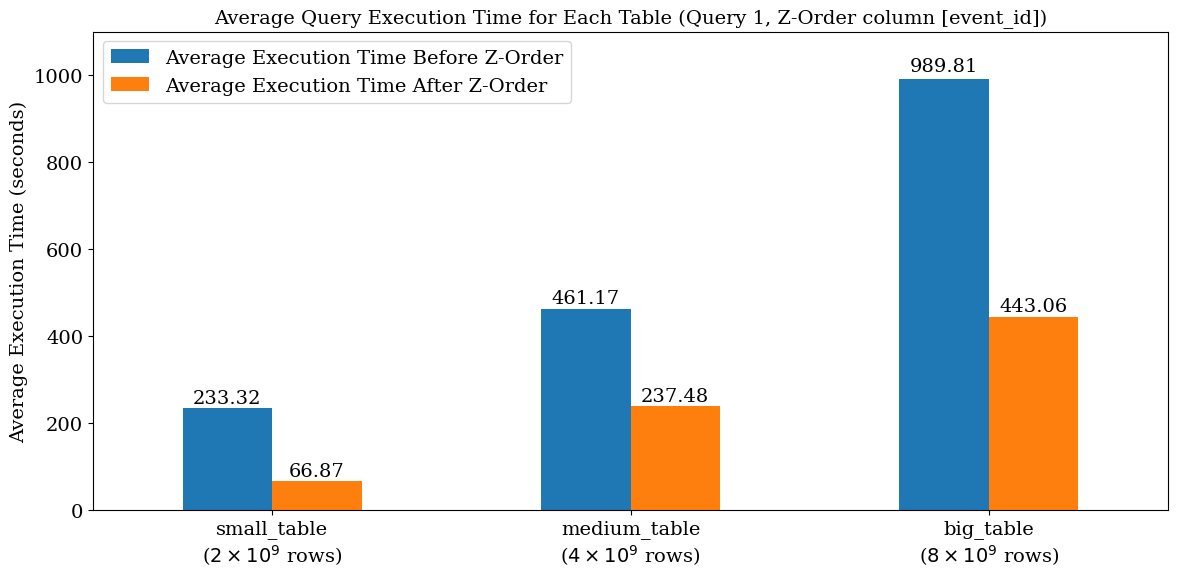

In [30]:
plot_comparison(average_times_part1_before, average_times_part1_after, "[event_id]")

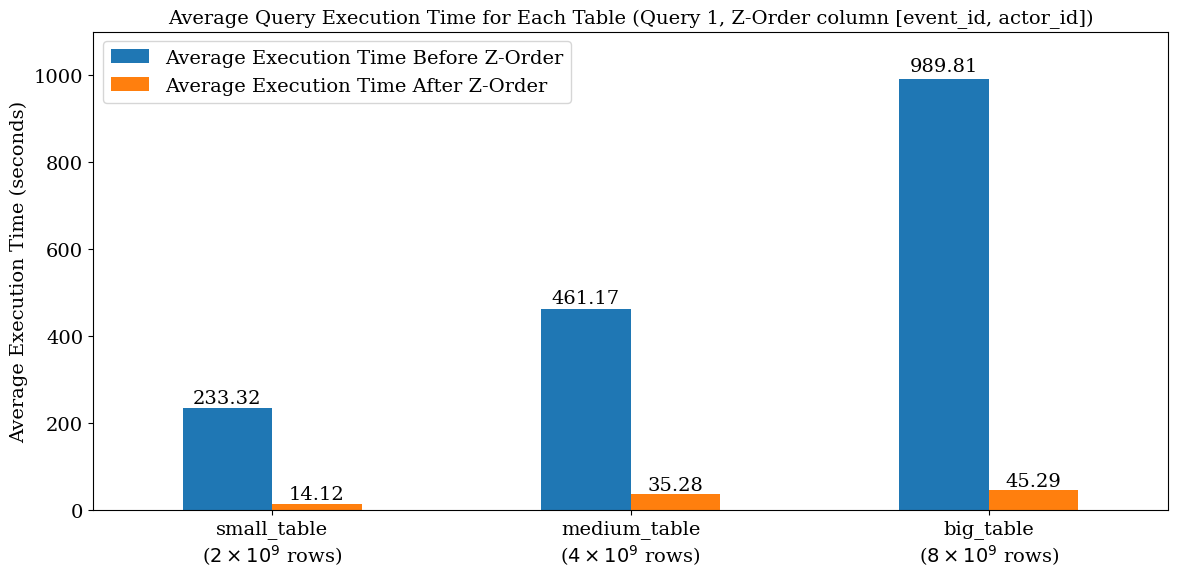

In [31]:
plot_comparison(average_times_part2_before, average_times_part2_after, "[event_id, actor_id]")

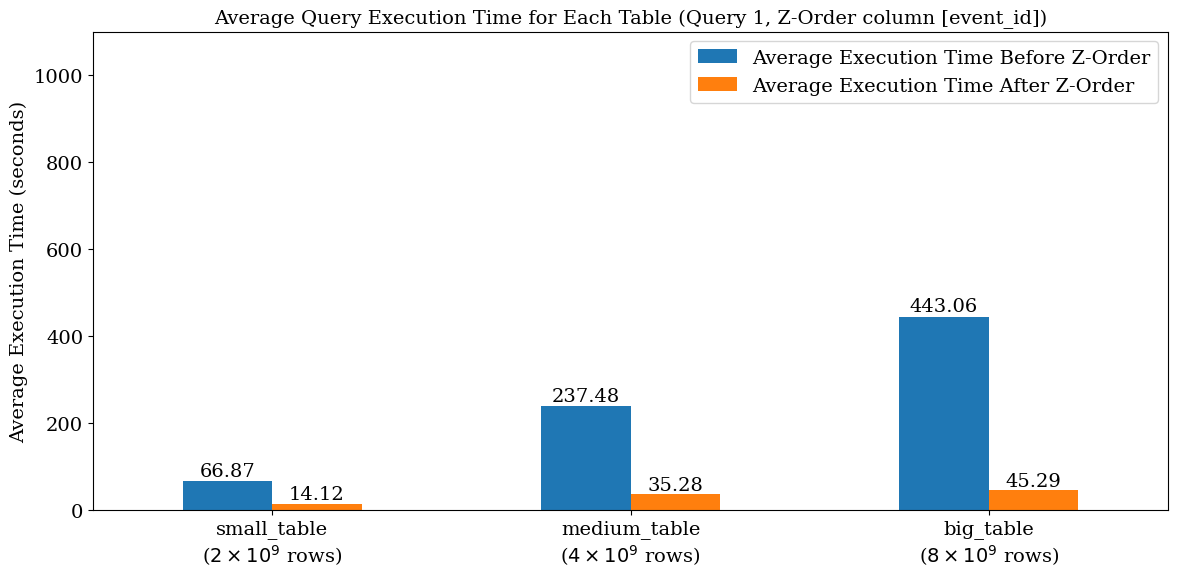

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

average_times_part1_before = {
    'small_table\n($2\\times10^9$ rows)': 66.869337,
    'medium_table\n($4\\times10^9$ rows)': 237.478777,
    'big_table\n($8\\times10^9$ rows)': 443.057015
}

average_times_part1_after = {
    'small_table\n($2\\times10^9$ rows)': 14.115593,
    'medium_table\n($4\\times10^9$ rows)': 35.281418,
    'big_table\n($8\\times10^9$ rows)': 45.288971
}

def plot_comparison(before_times, after_times, query_num):
    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  
    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})

    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Z-Order"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Z-Order"])
    df = df_before.merge(df_after, on="Table")

    ax = df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Query 1, Z-Order column {query_num})')
    plt.xticks(rotation=0)
    
    # Set y-axis limit to 500
    plt.ylim(0, 1100)

    # Annotate the bars with the values
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height * 1.01),  # Center and slightly above the bar
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'zorder_table_performance_{query_num}.png', dpi=500)
    plt.show()

plot_comparison(average_times_part1_before, average_times_part1_after, "[event_id]")


+--------------------+-------------------+-------------------+-------------------+-------------------+
|                path|min_increasing_int1|max_increasing_int1|min_increasing_int2|max_increasing_int2|
+--------------------+-------------------+-------------------+-------------------+-------------------+
|part-00000-3db53b...|                  1|           51048444|                  1|           51048444|
|part-00001-9c3944...|           50763053|           99905801|           50763053|           99905801|
|part-00002-a5951f...|           99670151|          148429046|           99670151|          148429046|
|part-00003-8753a2...|          148210156|          198300745|          148210156|          198300745|
|part-00004-c4f7d6...|          198259554|          249887875|          198259554|          249887875|
|part-00005-e9b547...|          249630218|          300000000|          249630218|          300000000|
+--------------------+-------------------+-------------------+-----------

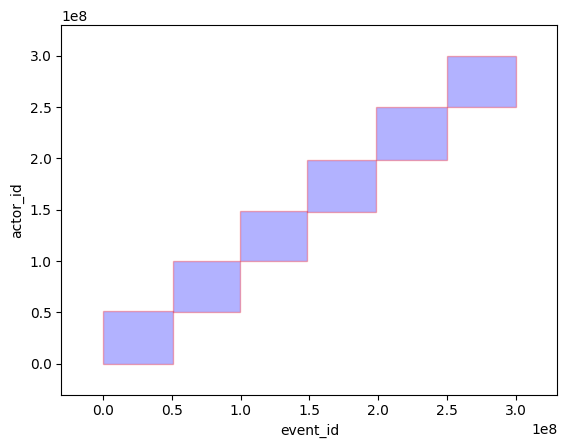

In [29]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row



file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_monotonic/_delta_log/00000000000000000002.json"

df = spark.read.text(file_path)

rows = []

for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['event_id']
        max_increasing_int1 = stats['maxValues']['event_id']
        min_increasing_int2 = stats['minValues']['actor_id']
        max_increasing_int2 = stats['maxValues']['actor_id']
        
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

result_df = spark.createDataFrame(rows)

rectangles = result_df.collect()
result_df.show()
fig, ax = plt.subplots()

for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='red', facecolor='blue', alpha=0.3)

    ax.add_patch(rectangle)

all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

ax.set_xlabel('event_id')
ax.set_ylabel('actor_id')

plt.savefig('zorder_monotonic.png', dpi=500)
plt.show()



+--------------------+-------------------+-------------------+-------------------+-------------------+
|                path|min_increasing_int1|max_increasing_int1|min_increasing_int2|max_increasing_int2|
+--------------------+-------------------+-------------------+-------------------+-------------------+
|part-00000-0d96dd...|                  0|              64462|                  0|               1278|
|part-00001-628568...|              32492|             129467|                  0|               1278|
|part-00002-05573f...|                  0|             129467|                636|               1920|
|part-00003-a5ce2e...|                  0|              76161|               1279|               2562|
|part-00004-d3519c...|              64463|             129467|               1279|               2562|
|part-00005-0cfaf5...|              96865|             193299|                  0|               2562|
|part-00006-34aecd...|             129468|             256970|           

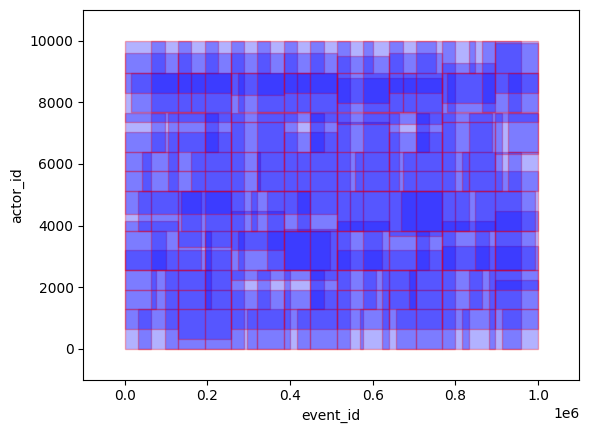

In [12]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row



file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_eventid_actorid_table_8000000000/_delta_log/00000000000000000002.json"

df = spark.read.text(file_path)

rows = []

for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['event_id']
        max_increasing_int1 = stats['maxValues']['event_id']
        min_increasing_int2 = stats['minValues']['actor_id']
        max_increasing_int2 = stats['maxValues']['actor_id']
        
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

result_df = spark.createDataFrame(rows)

rectangles = result_df.collect()
result_df.show()
fig, ax = plt.subplots()

for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='red', facecolor='blue', alpha=0.3)

    ax.add_patch(rectangle)

all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

ax.set_xlabel('event_id')
ax.set_ylabel('actor_id')

plt.savefig('zorder_monotonic.png', dpi=500)
plt.show()



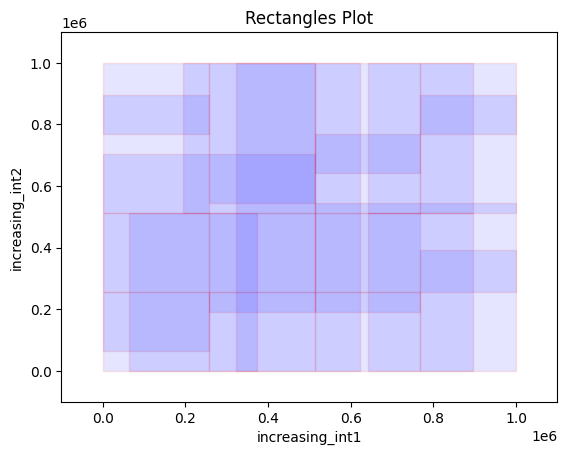

In [132]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row


file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_random/_delta_log/00000000000000000002.json"

df = spark.read.text(file_path)

rows = []

for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['random_int1']
        max_increasing_int1 = stats['maxValues']['random_int1']
        min_increasing_int2 = stats['minValues']['random_int2']
        max_increasing_int2 = stats['maxValues']['random_int2']
        
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

result_df = spark.createDataFrame(rows)

rectangles = result_df.collect()

fig, ax = plt.subplots()

for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.1)

    ax.add_patch(rectangle)

all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

ax.set_xlabel('increasing_int1')
ax.set_ylabel('increasing_int2')
ax.set_title('Rectangles Plot')

plt.savefig('zorder_monotonic.png', dpi=500)
plt.show()



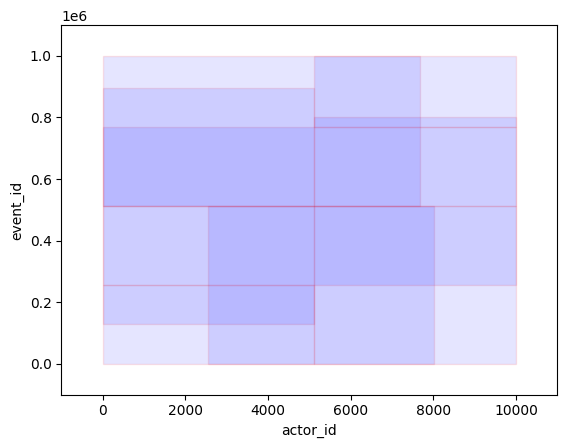

In [33]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row


file_path = "hdfs://192.168.0.144:9000/datalake/zorder/zorder_optimized_small/_delta_log/00000000000000000002.json"

df = spark.read.text(file_path)

rows = []

for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['actor_id']
        max_increasing_int1 = stats['maxValues']['actor_id']
        min_increasing_int2 = stats['minValues']['event_id']
        max_increasing_int2 = stats['maxValues']['event_id']
        
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

result_df = spark.createDataFrame(rows)

rectangles = result_df.collect()

fig, ax = plt.subplots()

for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.1)

    ax.add_patch(rectangle)

all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

ax.set_xlabel('actor_id')
ax.set_ylabel('event_id')

plt.savefig('zorder_random.png', dpi=500)
plt.show()

